<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/EXP/%5BE_06%5Dlyrics_del_verse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import os, re 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,WordPunctTokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import save_model, load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
txt_file_path = '/content/drive/MyDrive/Aiffel/data/lyrics.txt'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

In [4]:
for txt_file in txt_list:
    with open(txt_file,'r') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

In [5]:
print("데이터 크기:",len(raw_corpus))
print("Examples:\n",raw_corpus[:9])

데이터 크기: 187052
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained', 'It rode us all the way to New Orleans I pulled my harpoon out of my dirty red bandanna', "I was playin' soft while Bobby sang the blues, yeah", "Windshield wipers slappin' time, I was holdin' Bobby's hand in mine", "We sang every song that driver knew Freedom's just another word for nothin' left to lose", "Nothin', don't mean nothin' hon' if it ain't free, no no", "And, feelin' good was easy, Lord, when he sang the blues"]


## 텍스트 전처리
기본 베이스 코드 + 'verse'는 유의미한 가사가 아니라고 생각하여 삭제처리 추가

In [ ]:
##의미가 있는 단어라고 보기 어려운 verse 제거를 위한 확인작업 search가 verse만 잡아내는지 확인 (ex. abverseab를 인식하는가)
##무의미한 출력이 길어서 주석처리하겠습니다!
# for i in raw_corpus:
#   if re.search('verse',i) != None:
#     print(re.findall('verse',i))

In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1 문장의 소문자화 , 양쪽 공백 삭제
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2 특수문자 양쪽에 공백넣기 
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 공백이 복수일때 하나로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 불필요한 문자들 공백으로 바꾸기
    sentence = re.sub(r"verse", " ", sentence) # verse를 공백으로 바꿔버리기
    sentence = sentence.strip() # 5 양쪽의 공백 지우기
    sentence = '<start> ' + sentence + ' <end>' # 6 문장 앞뒤로 문자열 추가
    return sentence
for raw in raw_corpus[:2]:
    print(preprocess_sentence(raw))

<start> busted flat in baton rouge , waitin for a train <end>
<start> and i s feelin near as faded as my jeans <end>


In [8]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(re.split(' ',preprocessed_sentence)) <= 15: # 공백 기준으로 단어 개수 산정 15개를 넘지않는 선에서 리스트에 추가
          corpus.append(preprocessed_sentence)
        
corpus[:20] # la da 등 무의미 해보이는 단어이지만 노래 가사 이기때문에 이런 부분도 필요하다고 생각해서 제거하지않음.

['<start> busted flat in baton rouge , waitin for a train <end>',
 '<start> and i s feelin near as faded as my jeans <end>',
 '<start> bobby thumbed a diesel down , just before it rained <end>',
 '<start> i was playin soft while bobby sang the blues , yeah <end>',
 '<start> windshield wipers slappin time , i was holdin bobby s hand in mine <end>',
 '<start> you know , feelin good was good enough for me <end>',
 '<start> there bobby shared the secrets of my soul <end>',
 '<start> through all kinds of weather , through everything we done <end>',
 '<start> he s lookin for that home , and i hope he finds it <end>',
 '<start> nothin , that s all that bobby left me , yeah <end>',
 '<start> hey , feelin good was good enough for me , mm hmm <end>',
 '<start> good enough for me and my bobby mcghee la da da <end>',
 '<start> la da da da <end>',
 '<start> la da da da da da da da <end>',
 '<start> la da da da da da da da <end>',
 '<start> bobby mcghee , yeah la da da da da da da <end>',
 '<start> 

In [9]:
max(corpus,key=len)

'<start> take the beatdown we fuckin givin cmon motherfucker come on motherfuckers come on <end>'

## 토큰화
num_words를 어느정도로 설정해야 적정할지, 모델 학습에 어떤 영향을 줄지 이해가 조금 어려운 부분이 있었다. <'unk'>' 부분도 자주쓰인 단어 7000개 이외에는 블러처리 해버리겠다는 소리인지..? 만약에 가사 생성시 unk가 나와버리는 상황이 되면 어떻게 처리해야할지 의문.!

In [10]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 4006 1672 ...    0    0    0]
 [   2    8    4 ...    0    0    0]
 [   2  882 6820 ...    0    0    0]
 ...
 [   2   22   22 ...    3    0    0]
 [   2   22 4250 ...    0    0    0]
 [   2    3    0 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f39293b18d0>


In [11]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## train validation set 분리

In [12]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 4006 1672   14    1 4482    5 1293   28    9  634    3    0    0]
[4006 1672   14    1 4482    5 1293   28    9  634    3    0    0    0]


In [13]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=2020)

In [14]:
enc_train.shape,enc_val.shape

((124768, 14), (31192, 14))

In [15]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

In [16]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

## 모델 구성 및 학습
학습에 너무 오랜시간이 걸려서 LSTM을 추가로 쌓아본다던지 여러 시도를 하기는 어려웠던거 같다. 
- RNN모델에서 하이퍼파라미터 변화에 따른 정확도와 손실 성능 분석 논문에서 임베딩 사이즈가 모델에 가장 큰 영향을 준다고 했는데 실제로 2048보다 낮은 수들은 loss가 상대적으로 높았다.

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 2048
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [18]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[ 6.78904471e-04,  8.26236283e-05, -5.07510616e-04, ...,
         -4.82212519e-04,  8.32056277e-04, -1.29012187e-04],
        [ 1.52903807e-03,  3.65945685e-04, -9.63431085e-04, ...,
         -6.50505186e-04,  9.30133392e-04, -2.91815464e-04],
        [ 1.82287011e-03, -1.02898266e-04, -8.15897656e-04, ...,
         -7.98554509e-04,  8.97131569e-04, -3.62690684e-04],
        ...,
        [ 1.04694336e-03, -1.85119139e-03, -3.87571193e-03, ...,
          2.89592566e-03,  1.68899156e-03, -9.54587245e-04],
        [-2.80491833e-04, -2.14111479e-03, -3.63818486e-03, ...,
          2.32937466e-03,  1.03956729e-03, -2.10246793e-03],
        [-1.45949819e-03, -2.39880243e-03, -3.26365721e-03, ...,
          1.81012158e-03,  4.36620583e-04, -3.25342594e-03]],

       [[ 6.78904471e-04,  8.26236283e-05, -5.07510616e-04, ...,
         -4.82212519e-04,  8.32056277e-04, -1.29012187e-04],
        [ 7.18762283e-04,  2.08054844e-04, -5.

In [19]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  14338048  
                                                                 
 lstm (LSTM)                 multiple                  33562624  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  14345049  
                                                                 
Total params: 95,808,345
Trainable params: 95,808,345
Non-trainable params: 0
_________________________________________________________________


In [21]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he electric explore explore charged charged spring africa failed failed failed tha skill skill skill skill iv over over '

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)
MC = ModelCheckpoint('lyrics_best_model.tf', verbose=1, save_best_only=True)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          verbose=1,
          callbacks =[MC])

Epoch 1/10
487/487 [==============================] - ETA: 0s - loss: 3.0257 - accuracy: 0.5185
Epoch 1: val_loss improved from inf to 2.70832, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 152s 305ms/step - loss: 3.0257 - accuracy: 0.5185 - val_loss: 2.7083 - val_accuracy: 0.5427
Epoch 2/10
487/487 [==============================] - ETA: 0s - loss: 2.5410 - accuracy: 0.5563
Epoch 2: val_loss improved from 2.70832 to 2.47071, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 148s 303ms/step - loss: 2.5410 - accuracy: 0.5563 - val_loss: 2.4707 - val_accuracy: 0.5677
Epoch 3/10
487/487 [==============================] - ETA: 0s - loss: 2.2412 - accuracy: 0.5868
Epoch 3: val_loss improved from 2.47071 to 2.31855, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 148s 303ms/step - loss: 2.2412 - accuracy: 0.5868 - val_loss: 2.3185 - val_accuracy: 0.5899
Epoch 4/10
487/487 [==============================] - ETA: 0s - loss: 1.9609 - accuracy: 0.6227
Epoch 4: val_loss improved from 2.31855 to 2.20205, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 148s 303ms/step - loss: 1.9609 - accuracy: 0.6227 - val_loss: 2.2020 - val_accuracy: 0.6110
Epoch 5/10
487/487 [==============================] - ETA: 0s - loss: 1.7075 - accuracy: 0.6620
Epoch 5: val_loss improved from 2.20205 to 2.12500, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 147s 302ms/step - loss: 1.7075 - accuracy: 0.6620 - val_loss: 2.1250 - val_accuracy: 0.6301
Epoch 6/10
487/487 [==============================] - ETA: 0s - loss: 1.4952 - accuracy: 0.6999
Epoch 6: val_loss improved from 2.12500 to 2.07790, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 148s 304ms/step - loss: 1.4952 - accuracy: 0.6999 - val_loss: 2.0779 - val_accuracy: 0.6454
Epoch 7/10
487/487 [==============================] - ETA: 0s - loss: 1.3307 - accuracy: 0.7313
Epoch 7: val_loss improved from 2.07790 to 2.06233, saving model to lyrics_best_model.tf


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


INFO:tensorflow:Assets written to: lyrics_best_model.tf/assets


487/487 [==============================] - 148s 304ms/step - loss: 1.3307 - accuracy: 0.7313 - val_loss: 2.0623 - val_accuracy: 0.6572
Epoch 8/10
487/487 [==============================] - ETA: 0s - loss: 1.2086 - accuracy: 0.7567
Epoch 8: val_loss did not improve from 2.06233
487/487 [==============================] - 136s 279ms/step - loss: 1.2086 - accuracy: 0.7567 - val_loss: 2.0709 - val_accuracy: 0.6637
Epoch 9/10
487/487 [==============================] - ETA: 0s - loss: 1.1229 - accuracy: 0.7751
Epoch 9: val_loss did not improve from 2.06233
487/487 [==============================] - 136s 280ms/step - loss: 1.1229 - accuracy: 0.7751 - val_loss: 2.0870 - val_accuracy: 0.6674
Epoch 10/10
487/487 [==============================] - ETA: 0s - loss: 1.0658 - accuracy: 0.7875
Epoch 10: val_loss did not improve from 2.06233
487/487 [==============================] - 145s 298ms/step - loss: 1.0658 - accuracy: 0.7875 - val_loss: 2.1082 - val_accuracy: 0.6695


In [24]:
loaded_model = load_model('lyrics_best_model.tf')

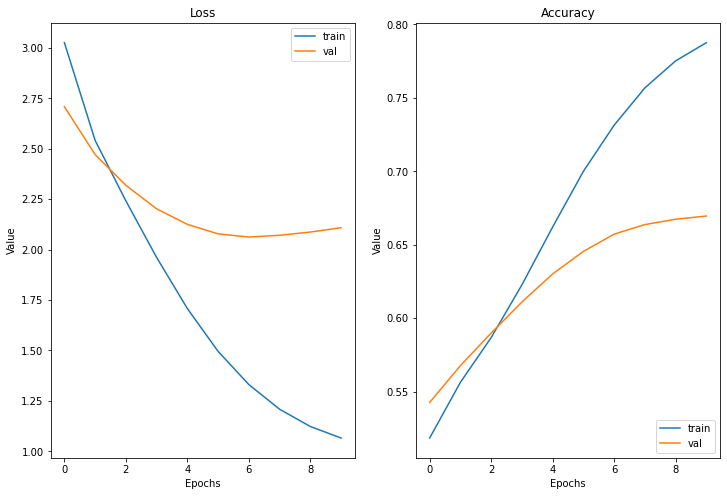

In [25]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [26]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am a god <end> '

# 회고록
전처리 단계에서 불용어를 제거해보려 여러가지 코드 작성을 작성해보았지만, 토큰화 함수에서 어느부분에 들어가줘야할지 몰라서 제대로 사용하지못하고 다시 빼버렸다. 정규표현식에 대한 이해가 상당히 필요하다는 것을 느꼈고, 문장을 받아와서 문장을 뱉는 형태라 그런지 구글링의 예시들과는 다르게 작성해야했던게 어려웠던 포인트이다.

학습에 상당한 시간이 소요되어(물론 실제보다는 훨씬 적은 양이지만..) 많은 상황에서의 모델 실험이 시간상 어려웠다. 주로 lr, 임베딩,히든사이즈 정도만 수치 변화를 주면서 여러 실험을 해보았지만 지금의 형태보다 더 나은 결과는 없었다.

이론적으로 본 NLP와 실제 코드상에서 어떻게 돌아가는지 매칭이 잘안되어서 어려웠던 EXP...였다.